In [ ]:
def draw_temporal_motif(edges):
    """
    Draws a temporal motif given a list of edges with their temporal order.
    Edges should be given as (source, target, order) tuples.
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges along with their temporal order as edge labels
    for edge in edges:
        source, target, order = edge
        G.add_edge(source, target, order=order)
    
    # Define positions for the nodes
    pos = nx.spring_layout(G)

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', arrowsize=20)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'order')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Show the plot
    plt.show()

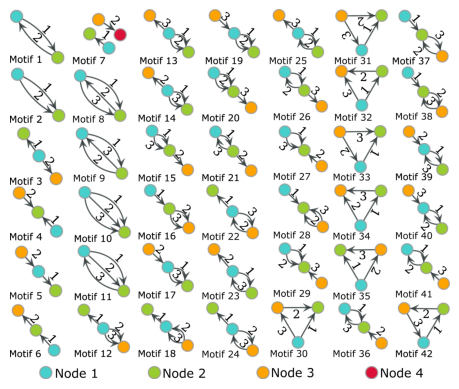

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image file
image = Image.open("figs/motifs_overall.png")  # Replace "path/to/your/image.jpg" with the actual path to your image

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: turn off axis labels
plt.show()

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [3]:
class MotifLSTM(nn.Module):
    def __init__(self):
        super(MotifLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

motiflstm = MotifLSTM().to(device)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(motiflstm.parameters(), lr=0.001, momentum=0.9)

from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Motif_Input_LSTM')

In [5]:
running_loss = 0.0
for epoch in range(2):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = motiflstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() / 4
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            print(running_loss / 1000)
            running_loss = 0.0

print('Finished Training')

0.4682996739074588
0.22769411802478134
0.1806587725719437
0.16358685179427265
0.1492319509239169
0.1419185471535311
0.1382095100362203
0.12500763507790544
0.12488500286068302
0.12260652860930714
0.11672496169799707
0.10822113941080169
0.10934366146071262
0.11268000038492028
0.10499080382220563
0.09989055119664408
0.10005015966866632
0.09626550488824978
0.09693897100958565
0.09694803928112378
0.08870798364870279
0.09521634270431968
0.09492867002077583
0.0953418028747983
0.09262700987762218
0.08709976065992668
0.08718567603408155
0.09458024782790926
0.08407680763394819
0.08192121385797509
Finished Training


In [9]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        # Define one convolutional layer
        self.conv1 = nn.Conv2d(1, 16, 5)  # Output channels changed to match the original fc1 input size
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size after convolution and pooling
        # (28 - 5 + 1) = 24 after conv1
        # 24 / 2 = 12 after pooling
        self.fc1 = nn.Linear(16 * 12 * 12, 120)  # Adjusted for 12x12 output from conv1
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply convolution, then pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 16 * 12 * 12)
        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

lstm = LSTM().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.001, momentum=0.9)

writer = SummaryWriter('runs/LSTM')

In [10]:
running_loss = 0.0
for epoch in range(2):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() / 4
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            print(running_loss / 1000)
            running_loss = 0.0

print('Finished Training')

0.29747318413015456
0.16281969798565843
0.13773663830116856
0.13374262149602872
0.12058917074471537
0.11552695603331085
0.10421619965517312
0.10093285577921779
0.09559173373256635
0.09569532948381675
0.0906322322490305
0.08829739868843171
0.08857017881295177
0.08695289780409075
0.08622152367090166
0.08266133724575048
0.07802065019897055
0.08248097637615866
0.07836876557540381
0.08028497238370255
0.07538256186843864
0.07880664475735102
0.07418406514876369
0.07583542192931418
0.07383955026636976
0.07603967656898748
0.07695556196267717
0.07370423997796934
0.07268339298409592
0.07686386640102864
Finished Training


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet([2, 2, 2, 2])

# Create the model
resnet18 = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

writer = SummaryWriter('runs/Motif_Guided_LSTM')

In [19]:
running_loss = 0.0
for epoch in range(2):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() / 4
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            print(running_loss / 1000)
            running_loss = 0.0

print('Finished Training')

0.23881796954479068
0.1495069475029595
0.13054218372312607
0.11222285669349366
0.10117796528997132
0.09600354146966128
0.08593264912793529
0.08431188292164006
0.0830250141901488
0.08056262385667651
0.07586529500675533
0.0722326482332137
0.07128157340781763
0.06870389555578003
0.07233499476697762
0.06394618501719379
0.06216817174958123
0.05895733376376302
0.06191895340337942
0.06003402047054988
0.0594361377237874
0.05650826937648526
0.06278901942780067
0.06126629226731893
0.055052386534451214
0.054237423458776905
0.05369588675384148
0.05880232880747644
0.055563743444843564
0.05417403622170241
Finished Training


In [ ]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir runs

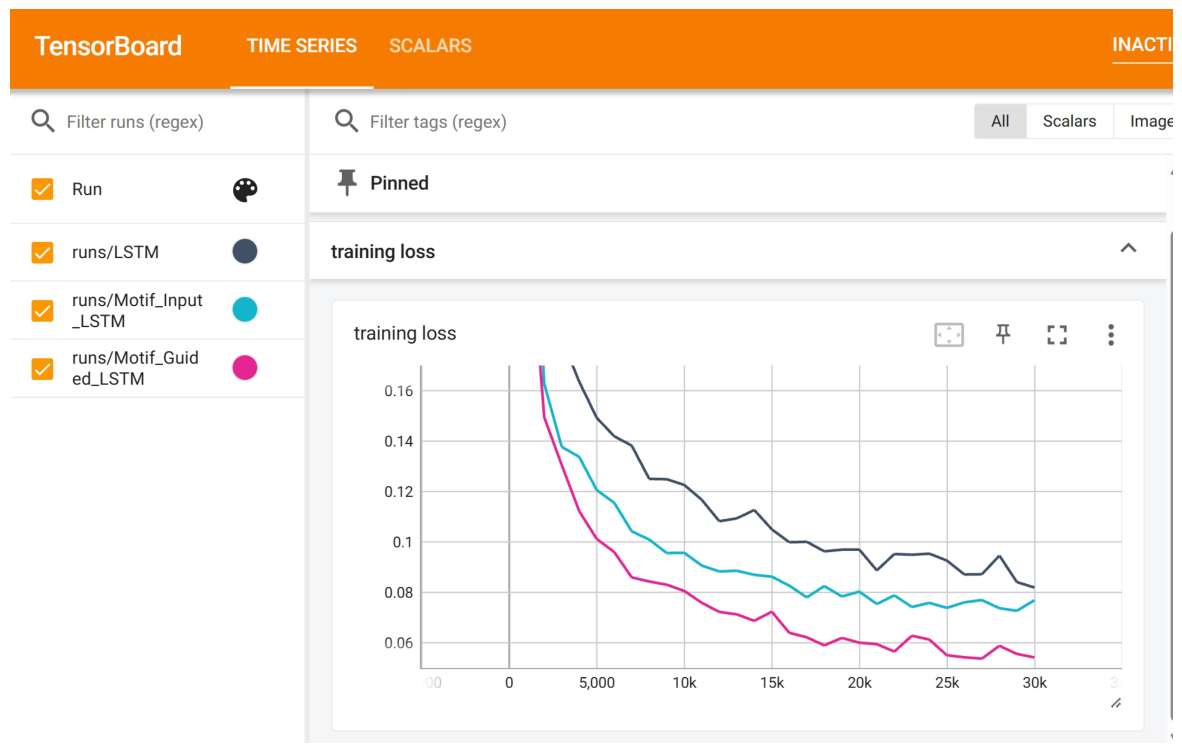

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image file
image = Image.open("figs/training.png")  # Replace "path/to/your/image.jpg" with the actual path to your image

# Set the figure size
plt.figure(figsize=(15, 15))  # Adjust the width and height values as needed

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: turn off axis labels
plt.show()